<a href="https://colab.research.google.com/github/vincent4u/Plant_disease-classification-Msc_thesis-/blob/main/MobileNet_model_1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing system libraries***

In [1]:
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# ***Creating important functions***

*Functions to Create DataFrame from Dataset*

In [2]:
# Function to generate file paths and corresponding labels from a given directory
def define_paths(data_dir):
    """
    This function iterates through directories and subdirectories within the provided data directory,
    collecting file paths and assigning them labels based on the parent directory they reside in.

    Parameters:
    - data_dir: The root directory where the data is stored.

    Returns:
    - A tuple containing two lists: filepaths (a list of absolute paths to all files) and labels (a list of labels corresponding to each file).
    """
    filepaths = []  # List to store absolute paths of all files
    labels = []     # List to store labels for each file

    # Get a list of all folders/directories in the data directory
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)  # Construct the full path to the current folder
        filelist = os.listdir(foldpath)           # Get a list of all files in the current folder
        for file in filelist:
            fpath = os.path.join(foldpath, file)  # Construct the full path to the current file
            filepaths.append(fpath)               # Append the file path to the list
            labels.append(fold)                   # Append the label (folder name) to the list

    return filepaths, labels





# Function to concatenate file paths and labels into a single DataFrame
def define_df(files, classes):
    """
    This function creates two pandas Series objects from the provided lists of file paths and labels,
    then concatenates these series side by side into a single DataFrame. This DataFrame will serve as the input
    for further processing, such as splitting into training, validation, and testing sets.

    Parameters:
    - files: A list of file paths.
    - classes: A list of labels corresponding to each file.

    Returns:
    - A DataFrame with two columns: 'filepaths' and 'labels', where 'filepaths' contains the paths to the files
      and 'labels' contains the corresponding labels.
    """
    Fseries = pd.Series(files, name='filepaths')  # Create a Series object for file paths
    Lseries = pd.Series(classes, name='labels')   # Create a Series object for labels
    return pd.concat([Fseries, Lseries], axis=1)  # Concatenate the two Series along the column axis


# Function to split the combined DataFrame into training, validation, and testing sets
def split_data(data_dir):
    """
    This function performs the following steps:
    1. Generates file paths and labels using the `define_paths` function.
    2. Combines these into a DataFrame using the `define_df` function.
    3. Splits the resulting DataFrame into training, validation, and testing sets, ensuring that the distribution
       of labels across these sets remains consistent (stratified sampling).

    Parameters:
    - data_dir: The root directory where the data is stored.

    Returns:
    - A tuple containing three DataFrames: train_df (for training), valid_df (for validation), and test_df (for testing).
    """
    # Step 1: Generate file paths and labels
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    # Extracting the labels for stratification
    strat = df['labels']

    # Step 2: Split the DataFrame into training and dummy sets (80% training)
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Step 3: Further split the dummy set into validation and testing sets (50% validation)
    strat = dummy_df['labels']  # Re-extracting the labels for stratification
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df



***Function to generate trainig,validation and test split set from th diretory***

In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    '''
    This function prepares image data generators for training, validation, and testing datasets.
    It uses Keras' ImageDataGenerator to preprocess images and convert them into tensors
    suitable for model training. The preprocessing includes resizing images to a standard size,
    applying data augmentation techniques like horizontal flipping, and converting images
    into categorical labels based on their file paths and labels columns.

    Parameters:
    - train_df: DataFrame containing training dataset with file paths and corresponding labels.
    - valid_df: DataFrame containing validation dataset with file paths and corresponding labels.
    - test_df: DataFrame containing testing dataset with file paths and corresponding labels.
    - batch_size: Number of samples per gradient update during training time.

    Returns:
    - train_gen: An instance of ImageDataGenerator for the training set.
    - valid_gen: An instance of ImageDataGenerator for the validation set.
    - test_gen: An instance of ImageDataGenerator for the testing set, using a custom batch size calculated to ensure that the total number of batches does not exceed 80.
    '''

    # Define the dimensions of the input images and the number of color channels.
    img_size = (224, 224)                                                       # Standard input size for the model.
    channels = 3                                                                # Using RGB images.
    color = 'rgb'                                                               # Color mode for the images.
    img_shape = (img_size[0], img_size[1], channels)                            # Shape of the input images.

    # Calculate the optimal batch size for the test set to ensure efficient memory usage.
    ts_length = len(test_df)  # Total number of samples in the test set.
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))  # Find the largest divisor of ts_length that divides evenly and keeps the number of batches below 80.
    test_steps = ts_length // test_batch_size                                   # Calculate the number of steps required to iterate over the entire test set.

    # Define a simple preprocessing function that returns the input image unchanged.
    def scalar(img):                                                                  # Placeholder function for demonstration purposes.
        return img

    # Create instances of ImageDataGenerator for both training and testing sets.
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)  # Apply horizontal flip for data augmentation.
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)                        # No data augmentation for the test set.

    # Generate data generators for the training, validation, and test sets.
    train_gen = tr_gen.flow_from_dataframe(
        train_df,
        x_col='filepaths',                                                             # Column name for file paths in the DataFrame.
        y_col='labels',                                                                # Column name for labels in the DataFrame.
        target_size=img_size,                                                          # Resize images to the specified size.
        class_mode='categorical',                                                      # Use categorical labels.
        color_mode=color,                                                              # Specify the color mode.
        shuffle=True,                                                                  # Shuffle the data.
        batch_size=batch_size                                                          # Batch size for training.
    )

    valid_gen = ts_gen.flow_from_dataframe(
        valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=True,
        batch_size=batch_size
    )

    # For the test set, use the custom batch size calculation and disable shuffling.
    test_gen = ts_gen.flow_from_dataframe(
        test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=img_size,
        class_mode='categorical',
        color_mode=color,
        shuffle=False,                                  # Do not shuffle the test set.
        batch_size=test_batch_size
    )

    return train_gen, valid_gen, test_gen


**Visualizing the images with thier respective labels**

In [4]:
def show_images(gen):
    '''
    This function displays a sample of images generated by the given data generator.
    It retrieves a batch of images along with their labels from the generator,
    selects a subset of these images for display, and then plots them using matplotlib.
    Each image is labeled with its predicted class name.

    Parameters:
    - gen: A data generator object, typically returned by methods like flow_from_directory() or
    flow_from_dataframe() in Keras' ImageDataGenerator.

    Notes:
    - The function assumes that the data generator yields batches of images and their corresponding labels.
    - The number of images displayed is limited to a maximum of 25 to avoid cluttering the plot.
    - Images are normalized to the range [0, 255] for better visualization.
    '''

    # Retrieve the mapping between class indices and class names from the generator.
    g_dict = gen.class_indices                                                        # Dictionary mapping class names to indices. defines dictionary {'class': index}
    classes = list(g_dict.keys())                                                     # List of class names extracted from the dictionary keys.

    # Fetch a batch of images and their labels from the generator.
    images, labels = next(gen)                                                        # Get a batch of images and their labels.

    # Determine the number of images to display, up to a maximum of 25.
    length = len(labels)                                                              # Length of the batch.
    sample = min(length, 25)                                                          # Limit the number of displayed images to 25 or fewer.

    # Initialize a figure for plotting the images.
    plt.figure(figsize=(20, 20))                                                      # Set the figure size.

    # Loop through the selected images and plot each one.
    for i in range(sample):
        plt.subplot(5, 5, i + 1)                                                      # Position the subplot.

        # Normalize the image pixel values to the range [0, 255].
        image = images[i] / 255

        # Display the image.
        plt.imshow(image)

        # Retrieve the label index of the current image.
        index = np.argmax(labels[i])

        # Extract the class name corresponding to the label index.
        class_name = classes[index]

        # Add a title to the subplot indicating the class name.
        plt.title(class_name, color='blue', fontsize=12)

        # Hide axes for cleaner visualization.
        plt.axis('off')

    # Display the figure with the plotted images.
    plt.show()


# ***Implementing a callback***

  
    Custom callback class for dynamic learning rate adjustment and
    early stopping based on training and validation metrics.

    This callback dynamically adjusts the learning rate based on the performance of the model
    on the training and validation datasets. It also implements early stopping based on a specified number
    of epochs without improvement in validation loss.

    Parameters:
    - model: The Keras model to which this callback is attached.
    - patience: Number of epochs with no improvement after which learning rate is reduced.
    - stop_patience: Number of times the learning rate can be reduced before stopping training.
    - threshold: Training accuracy threshold for adjusting the learning rate based on validation loss.
    - factor: Factor by which to reduce the learning rate.
    - batches: Number of training batches to run per epoch.
    - epochs: Total number of epochs to train for.
    - ask_epoch: Optional parameter to prompt the user to decide whether to continue training past
    a certain epoch.
  

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience                                                                  # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience                                                        # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold                                                                # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor                                                                      # factor by which to reduce the learning rate
        self.batches = batches                                                                    # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch                                                        # save this value to restore if restarting training

        # callback variables
        self.count = 0                                                                            # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1                                                                       # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr))                   # get the initial learning rate and save it
        self.highest_tracc = 0.0                                                                  # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf                                                                # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights()                                              # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()                                           # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')                                                                      # get training accuracy
        v_acc = logs.get('val_accuracy')                                                                # get validation accuracy
        loss = logs.get('loss')                                                                         # get training loss for this epoch
        v_loss = logs.get('val_loss')                                                                   # get the validation loss for this epoch

        if acc < self.threshold:                                                                        # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:                                                        # check if the validation loss improved
                self.lowest_vloss = v_loss                                                        # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights()                                      # validation loss improved so save the weights
                self.count = 0                                                                    # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')


***Plot Function for visualizing the Training History indicating accuracy and loss results***

In [6]:
def plot_training(hist):
    '''
    This function takes a training model's history object and plots the training and validation accuracy and loss over epochs,
    highlighting the epoch with the best validation loss and accuracy.
    '''

    # Extracting training and validation metrics from the history object
    tr_acc = hist.history['accuracy']                                       # Training accuracy
    tr_loss = hist.history['loss']                                          # Training loss
    val_acc = hist.history['val_accuracy']                                  # Validation accuracy
    val_loss = hist.history['val_loss']                                     # Validation loss

    # Identifying the epoch with the lowest validation loss and highest validation accuracy
    index_loss = np.argmin(val_loss)                                        # Index of the epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]                                       # Value of the lowest validation loss
    index_acc = np.argmax(val_acc)                                          # Index of the epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]                                        # Value of the highest validation accuracy

    # Creating a list of epochs for plotting
    Epochs = [i+1 for i in range(len(tr_acc))]                              # Adjusting epoch numbers to start from 1

    # Labels for the best epoch in terms of loss and accuracy
    loss_label = f'best epoch= {str(index_loss + 1)}'                        # Label for the best epoch in terms of validation loss
    acc_label = f'best epoch= {str(index_acc + 1)}'                          # Label for the best epoch in terms of validation accuracy

    # Plotting training and validation loss
    plt.figure(figsize=(20, 8))                                             # Setting figure size
    plt.style.use('fivethirtyeight')                                        # Using a style for the plot

    plt.subplot(1, 2, 1)                                                    # Subplot for loss
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')                   # Plotting training loss
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')                 # Plotting validation loss
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)  # Highlighting the best epoch in terms of validation loss
    plt.title('Training and Validation Loss')                                   # Title for the subplot
    plt.xlabel('Epochs')                                                    # X-axis label
    plt.ylabel('Loss')                                                      # Y-axis label
    plt.legend()                                                            # Displaying legend

    plt.subplot(1, 2, 2)                                                    # Subplot for accuracy
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')                # Plotting training accuracy
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')             # Plotting validation accuracy
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)  # Highlighting the best epoch in terms of validation accuracy
    plt.title('Training and Validation Accuracy')                               # Title for the subplot
    plt.xlabel('Epochs')                                                        # X-axis label
    plt.ylabel('Accuracy')                                                      # Y-axis label
    plt.legend()                                                                # Displaying legend

    plt.tight_layout()                                                          # Adjusting layout to prevent overlapping labels
    plt.show()                                                                  # Displaying the plot


# ***Loading the Dataset from Kaggle Database***

This also involves utilizing the already exisitng functions like
def define_paths(data_dir)
def define_df(files, classes)
def split_data(data_dir)
def create_gens(train_df, valid_df, test_df, batch_size)
def show_images(gen)


Streaming output truncated to the last 5000 lines.
  inflating: data_sets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: data_sets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: data_sets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: data_sets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-b563-438d-b9ed-7476153023ce___YLCV_GCREC 2258.JPG  
  inflating: data_sets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/092330d8-f6e9-48df-8525-cb391b8f00b7___YLCV_GCREC 2930.JPG  
  inflating: data_sets/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09266523-41f5-42cd-bf15-5f13a6cec876___UF.GRC_YLCV_Lab 02419.JPG  
  inflating: data_sets/plantvillage/PlantVillage/

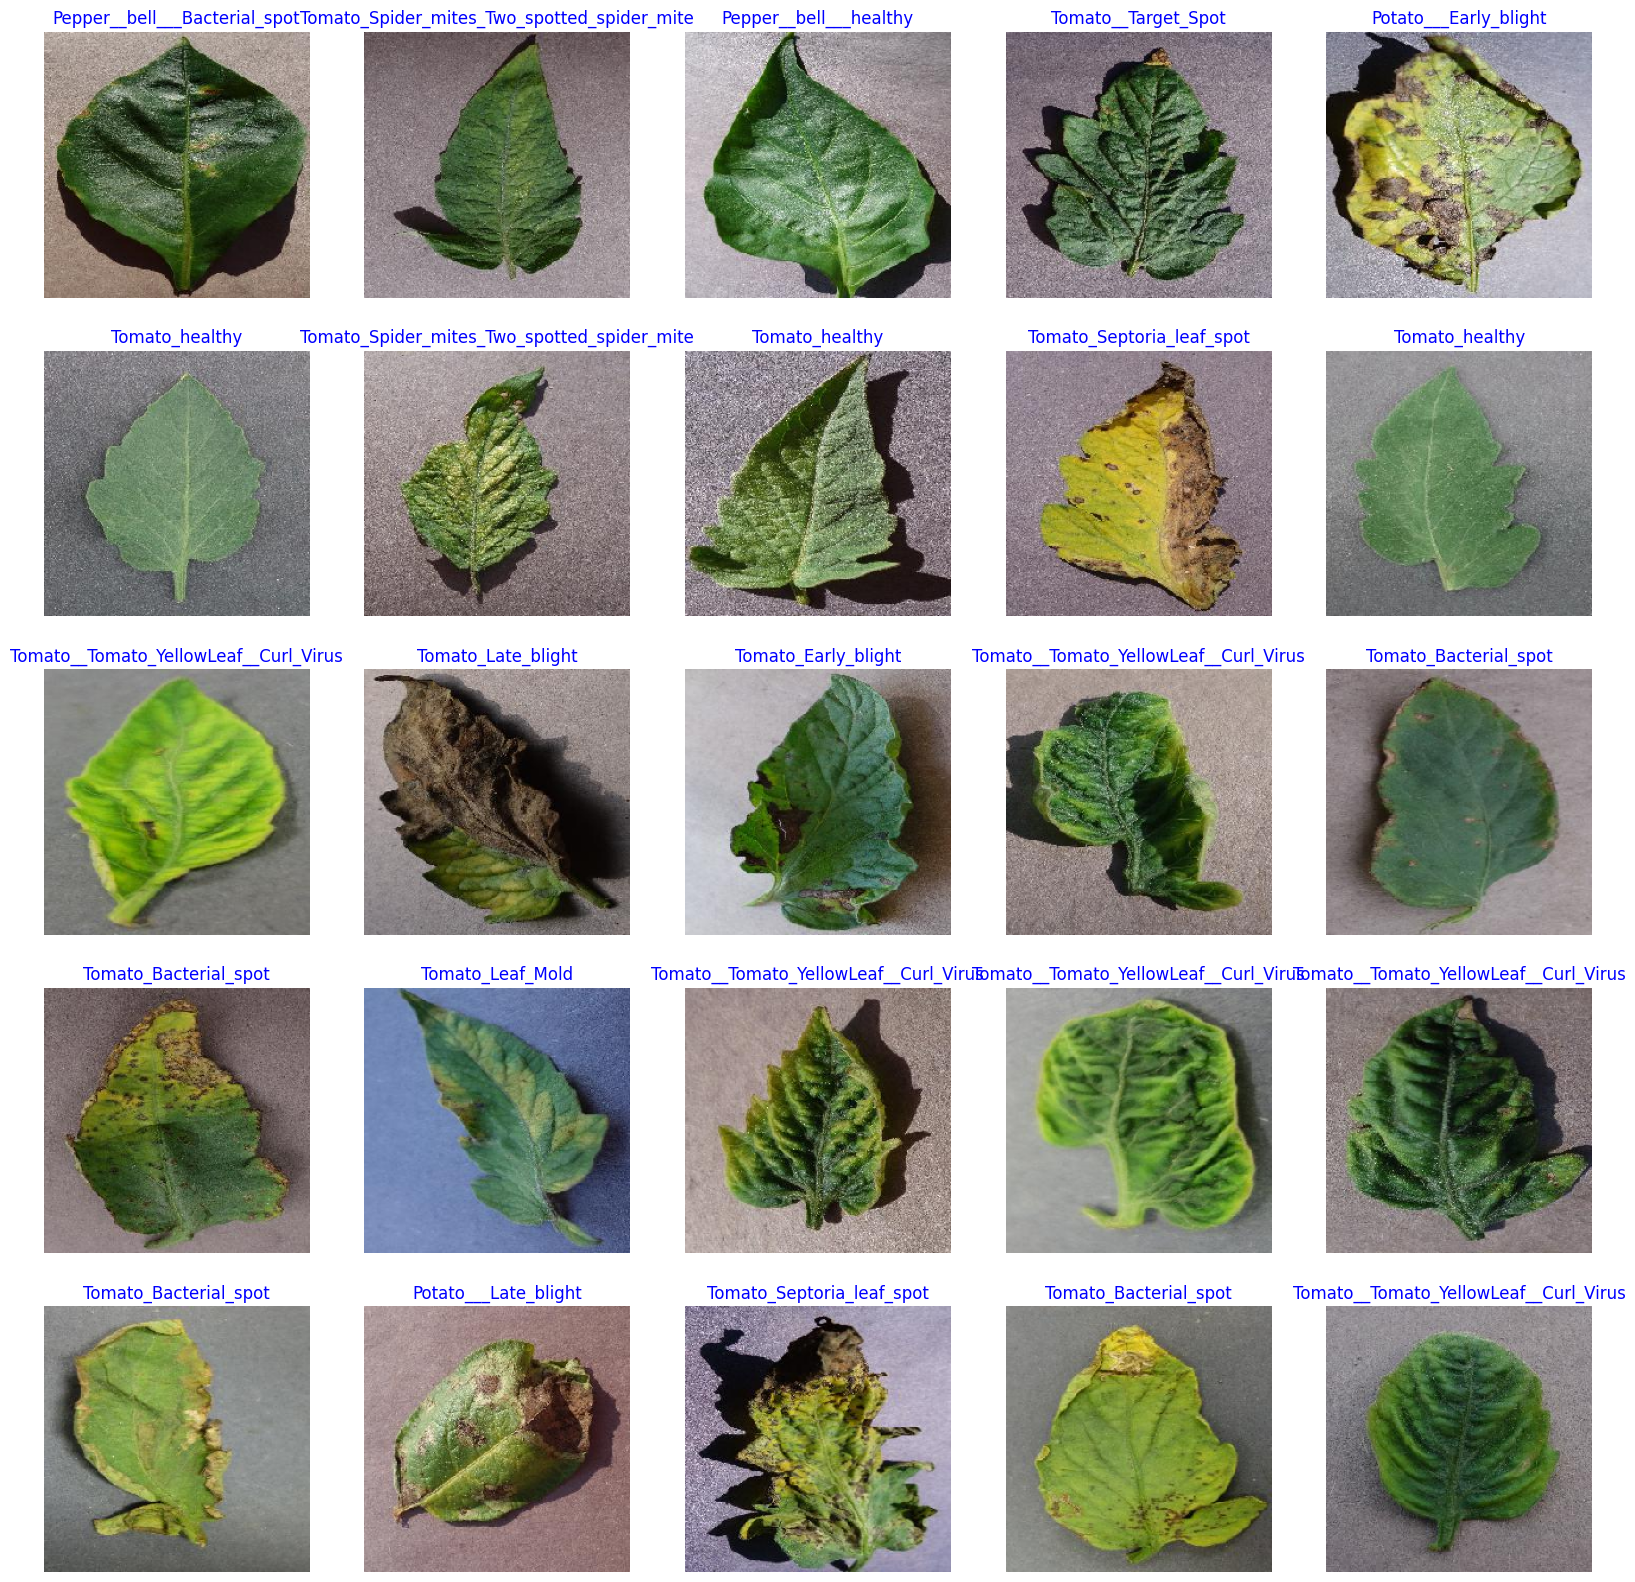

In [7]:
# I have already done step 1 with the seceret thing

#Step 2: Accessing and Exporting Kaggle secrets to the environment
from google.colab import userdata
import os
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

#Step 3: Download Dataset :
!kaggle datasets download -d emmarex/plantdisease
# !kaggle datasets download -d abdallahalidev/plantvillage-dataset

! mkdir data_sets
! unzip plantdisease.zip -d data_sets

# ! mkdir data_vin
# ! unzip plantvillage-dataset.zip -d data_vin


data_dir = '/content/data_sets/plantvillage/PlantVillage'
try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)
    show_images(train_gen)
except:
    print('Invalid Input')


# ***Implementing My Model***
This is my own modification of the MobileNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, Add, AvgPool2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNet



class_count = len(list(train_gen.class_indices.keys())) # Define number of classes in the dense layer


# Defining the my improved MobileNet block
def mobilenet_block(x, filters, kernel_size, strides):
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)    # Apply Depthwise Convolution with specified kernel size and strides
    x = BatchNormalization()(x)                                                         # Apply Batch Normalization to the output of Depthwise Convolution
    x = ReLU()(x)                                                                       # Apply ReLU activation function

    x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)                    # Apply Pointwise Convolution with 1x1 kernel
    x = BatchNormalization()(x)                                                         # Apply Batch Normalization to the output of Pointwise Convolution
    x = ReLU()(x)                                                                       # Apply ReLU activation function

    return x

# Defining the stage function of MobileNet
def stage(x, filters, repetitions, strides):
    x = mobilenet_block(x, filters=filters, kernel_size=3, strides=strides)             # Apply the first MobileNet block with specified strides (for downsampling)
    for _ in range(repetitions - 1):                                                    # Apply the remaining MobileNet blocks with stride 1 (no downsampling)
        x = mobilenet_block(x, filters=filters, kernel_size=3, strides=1)
    return x

# Input shape
input_shape = (224, 224, 3)                                                             # Defines the input shape for the model (224x224 RGB image)
input_tensor = Input(shape=input_shape)                                                 # Create the input tensor

# Initial layers
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input_tensor)          # Apply initial Conv2D layer with 32 filters, 3x3 kernel, and stride 2 for downsampling
x = BatchNormalization()(x)                                                             # Apply Batch Normalization to the output of the Conv2D layer
x = ReLU()(x)                                                                           # Apply ReLU activation function
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)                                # Apply MaxPooling with 3x3 pool size and stride 2 for further downsampling

# Stages
repetitions = [3, 7, 3]                                                                 # Define the number of repetitions for each stage
filters = [64, 128, 256]                                                                # Define the number of filters for each stage
strides = [1, 2, 2]                                                                     # Define the strides for the first block of each stage (for downsampling)

# Apply each stage with the corresponding repetitions, filters, and strides
for reps, f, s in zip(repetitions, filters, strides):
    x = stage(x, filters=f, repetitions=reps, strides=s)

# Final layers
x = GlobalAveragePooling2D()(x)                                                                              # Apply Global Average Pooling to reduce the spatial dimensions to 1x1
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)                                     # Apply a Dense layer with 256 units and various regularizers
x = Dropout(rate=0.45, seed=123)(x)                                                                          # Apply Dropout with a rate of 0.45 for regularization
output_tensor = Dense(class_count, activation='softmax')(x)                                                  # Apply the final Dense layer with units equal to the number of classes and softmax activation

# Create model
model = Model(inputs=input_tensor, outputs=output_tensor)                               # Create the Keras model
model.summary()                                                                         # Print the model summary

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),                                    # Use Adamax optimizer with specified learning rate
              loss='categorical_crossentropy',                                          # Use categorical crossentropy loss
              metrics=['accuracy'])                                                     # Track accuracy as the metric


# Training parameters
batch_size = 40                                                                         # Set batch size for training
epochs = 40                                                                             # Number of epochs in training
patience = 1                                                                            # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3                                                                       # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9                                                                         # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5                                                                            # Factor to reduce learning rate by
ask_epoch = 5                                                                           # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))                              # Number of training batches to run per epoch

# Define callbacks (assuming MyCallback is defined elsewhere in your code)
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Fit the model
history = model.fit(x=train_gen, epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=valid_gen, validation_steps=None, shuffle=False)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 32)        0         
 D)                                                              
                                                                 
 depthwise_conv2d (Depthwis  (None, 56, 56, 32)        320   

# ***Evaluating my lighweight model's performance***

# New Model Evaluation performance and computational complexcities:
This Includes the following:
1. The parameter count
2. The Inferenece Time
3. The Memory usage
4. FLOPs
5. The actibvation count
I am keeping this one.

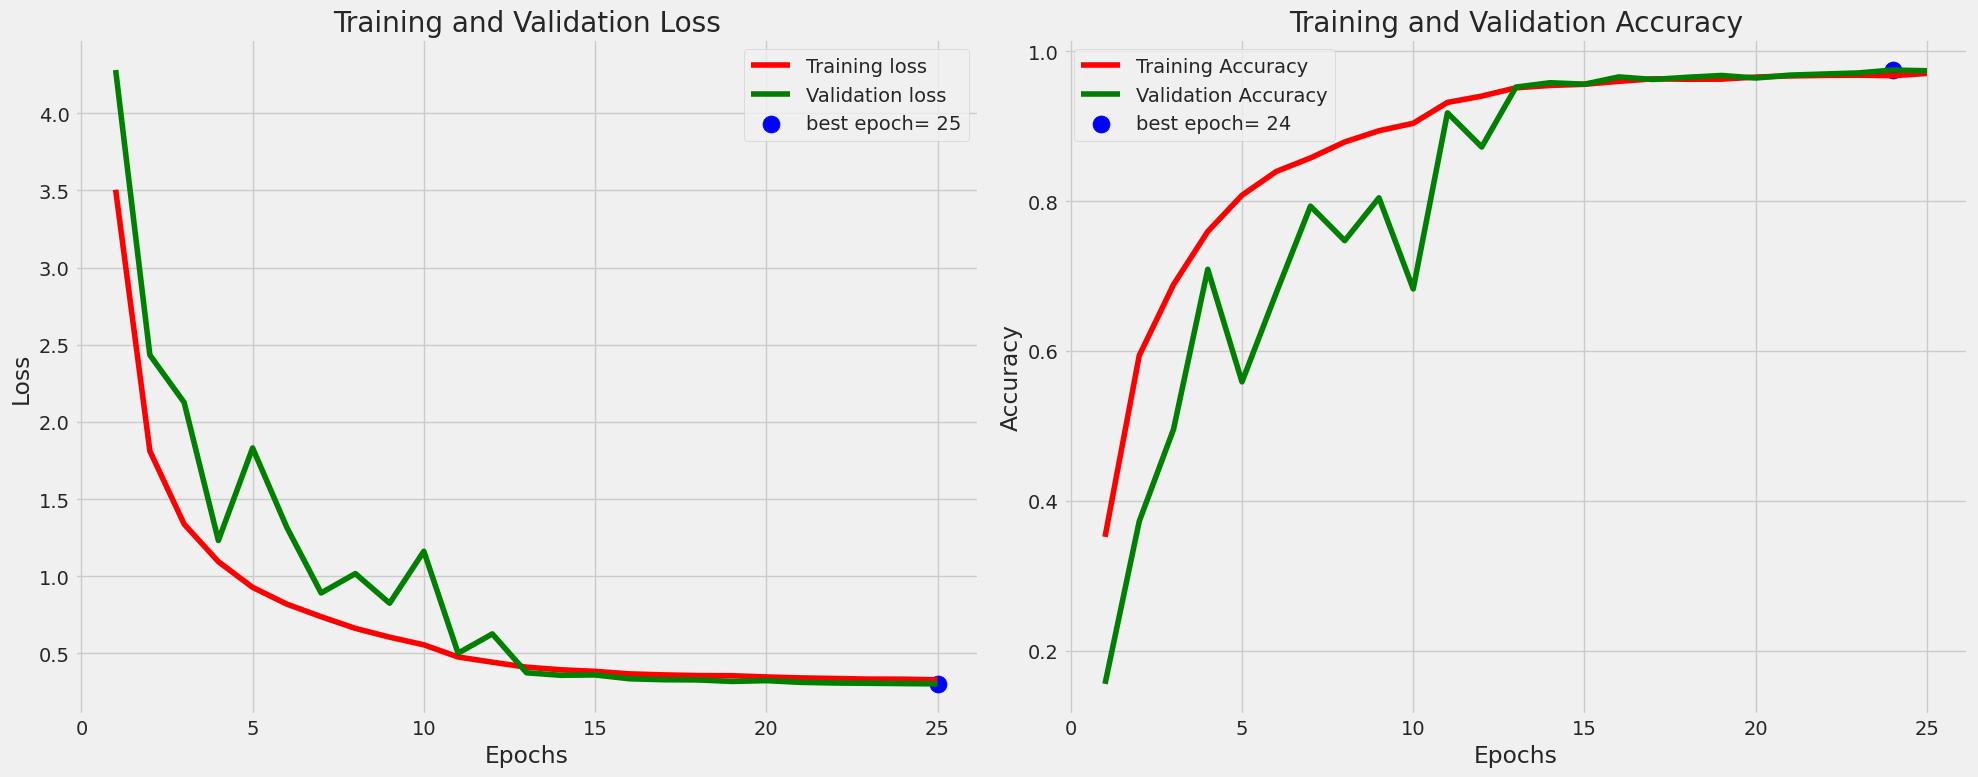

43/43 [==============================] - 5s 106ms/step - loss: 0.3109 - accuracy: 0.9637
Train Loss:  0.2427700012922287
Train Accuracy:  0.9924418330192566
--------------------
Validation Loss:  0.30419158935546875
Validation Accuracy:  0.9726744294166565
--------------------
Test Loss:  0.3108604848384857
Test Accuracy:  0.9636628031730652
Total number of parameters: 383375
Estimated memory usage: 1.46 MB
1/1 [==============================] - 0s 22ms/step
Inference time for a single input: 0.078374 seconds
Total FLOPs: 0
Activation counts by layer:
input_1: (None, 224, 224, 3)
conv2d: (None, 112, 112, 32)
batch_normalization: (None, 112, 112, 32)
re_lu: (None, 112, 112, 32)
max_pooling2d: (None, 56, 56, 32)
depthwise_conv2d: (None, 56, 56, 32)
batch_normalization_1: (None, 56, 56, 32)
re_lu_1: (None, 56, 56, 32)
conv2d_1: (None, 56, 56, 64)
batch_normalization_2: (None, 56, 56, 64)
re_lu_2: (None, 56, 56, 64)
depthwise_conv2d_1: (None, 56, 56, 64)
batch_normalization_3: (None, 56, 5

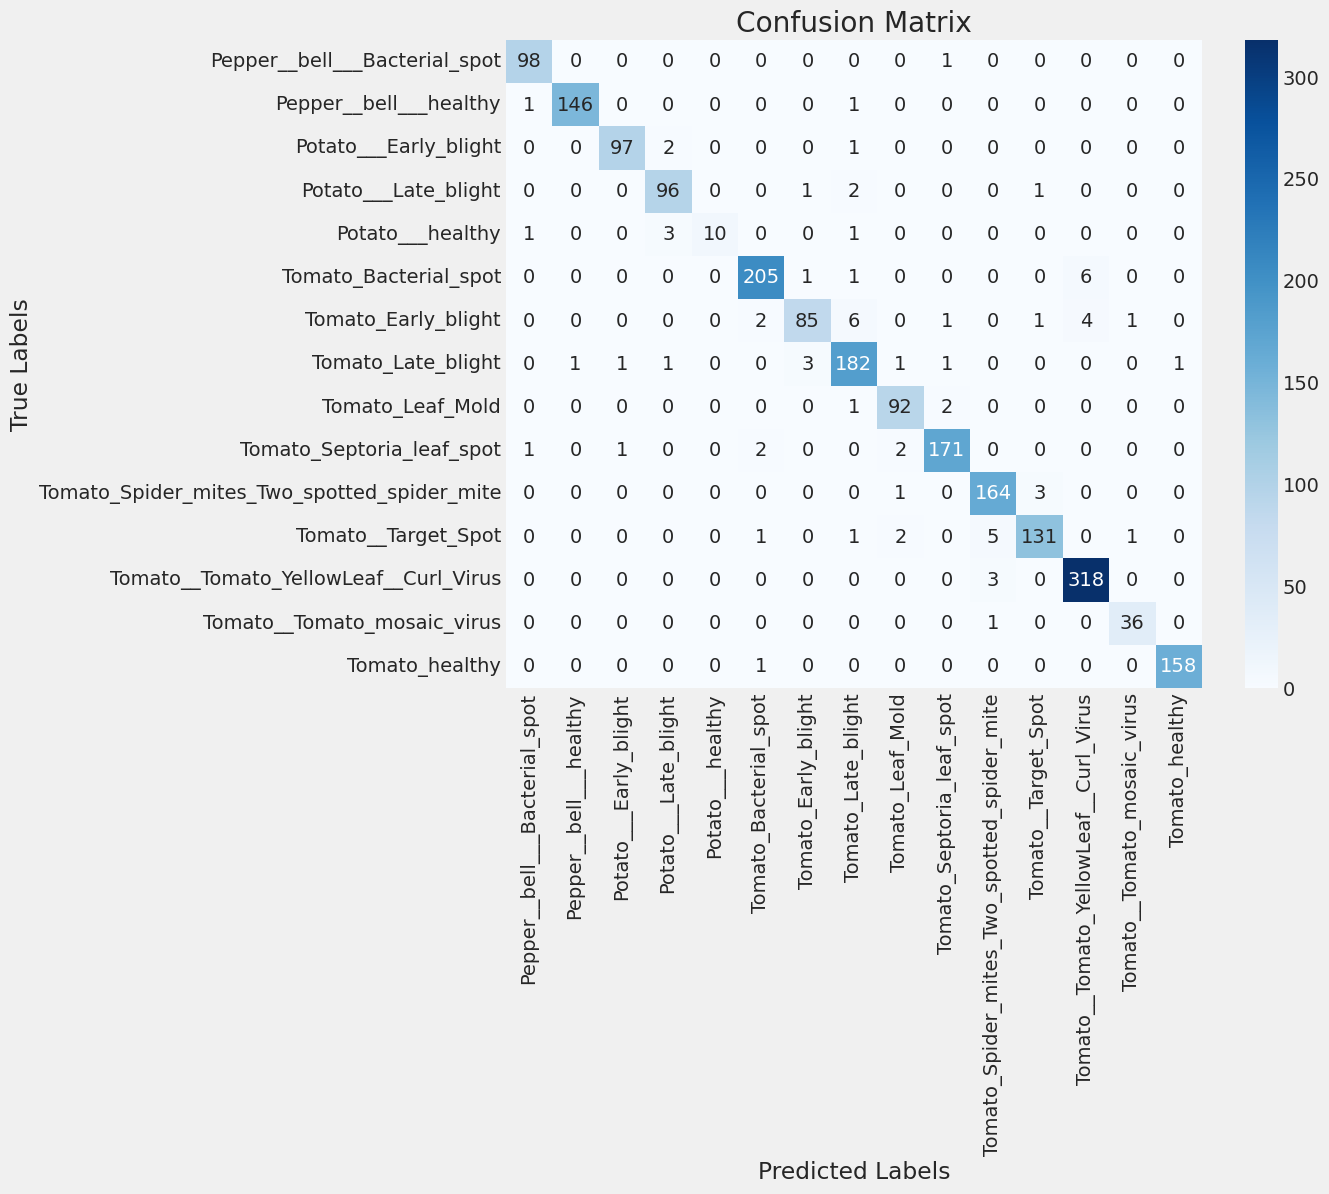

model was saved as i-Plant Village Disease-96.37.h5
weights were saved as i-Plant Village Disease-weights.h5
class csv file was saved as Plant Village Disease-class_dict.csv


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Plot training history
plot_training(history)

# Determine the test batch size that evenly divides the test dataset and is less than or equal to 80
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model on the training, validation, and test sets
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

# Print the evaluation results
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Additional Metrics Calculation
# Parameter Count
total_params = model.count_params()
print(f"Total number of parameters: {total_params}")

# Memory Usage
memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision, hence 4 bytes per parameter
print(f"Estimated memory usage: {memory_usage:.2f} MB")

# Inference Time
input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
start_time = time.time()
model.predict(input_data)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time for a single input: {inference_time:.6f} seconds")

# FLOPs Calculation
def get_flops(model):
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph = frozen_func.graph
    with tf.Graph().as_default() as g:
        tf.import_graph_def(graph.as_graph_def(), name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

flops = get_flops(model)
print(f"Total FLOPs: {flops:,}")

# Activation Count
def get_activation_count(model):
    activations = {}
    for layer in model.layers:
        if hasattr(layer, 'output'):
            activations[layer.name] = layer.output.shape
    return activations

activation_counts = get_activation_count(model)
print("Activation counts by layer:")
for layer_name, shape in activation_counts.items():
    print(f"{layer_name}: {shape}")

# Calculate total activations, ignoring None shapes
total_activations = sum(np.prod(shape) for shape in activation_counts.values() if None not in shape)
print(f"Total number of activations: {total_activations:,}")

# Generate predictions using the test generator
preds = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(preds, axis=1)  # Get the predicted class indices
print(y_pred)

# Get class indices from the test generator
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

# Construct the confusion matrix
conf_matrix = confusion_matrix(test_gen.classes, y_pred)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Define model and save parameters
model_name = model.input_names[0][:-6]  # Extract model name by trimming the input layer suffix
subject = 'Plant Village Disease'
acc = test_score[1] * 100  # Convert accuracy to percentage
save_path = ''  # Define save path (empty for current directory)

# Save the trained model
save_id = str(f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save the model weights separately
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

# Generate class dictionary DataFrame
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = [img_size[0]] * len(class_dict)  # List of image heights
width = [img_size[1]] * len(class_dict)  # List of image widths

# Create Series for DataFrame
Index_series = pd.Series(list(class_dict.values()), name='class_index')
Class_series = pd.Series(list(class_dict.keys()), name='class')
Height_series = pd.Series(height, name='height')
Width_series = pd.Series(width, name='width')

# Concatenate Series into DataFrame
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis=1)

# Save class dictionary DataFrame to CSV
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index=False)
print(f'class csv file was saved as {csv_save_loc}')


# ***Comparing other mobileNet models***

# ***Implemetning MobileNet V_1***

17225924/17225924 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                              

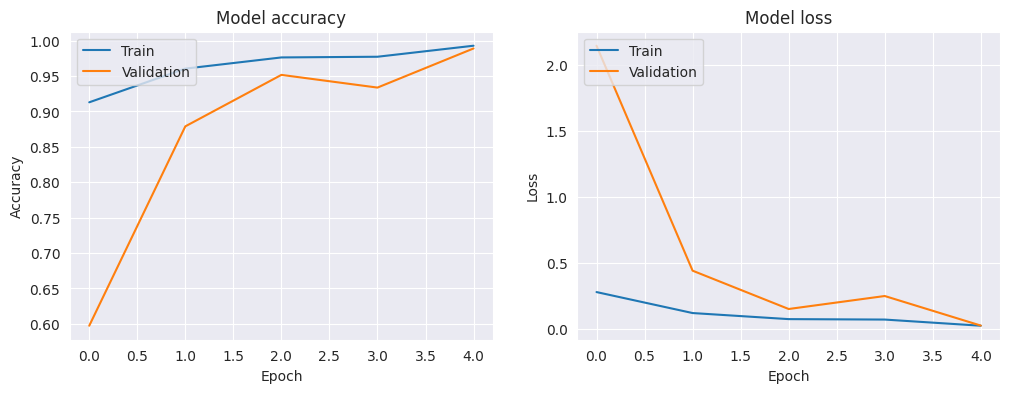

43/43 [==============================] - 5s 83ms/step - loss: 0.0257 - accuracy: 0.9932
Train Loss: 0.006691792048513889 Train Accuracy: 0.9979406595230103
Validation Loss: 0.024219682440161705 Validation Accuracy: 0.9888566136360168
Test Loss: 0.02571367658674717 Test Accuracy: 0.9932170510292053
43/43 [==============================] - 4s 93ms/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00        99
                     Pepper__bell___healthy       1.00      1.00      1.00       148
                      Potato___Early_blight       1.00      1.00      1.00       100
                       Potato___Late_blight       1.00      1.00      1.00       100
                           Potato___healthy       1.00      1.00      1.00        15
                      Tomato_Bacterial_spot       0.98      1.00      0.99       213
                        Toma

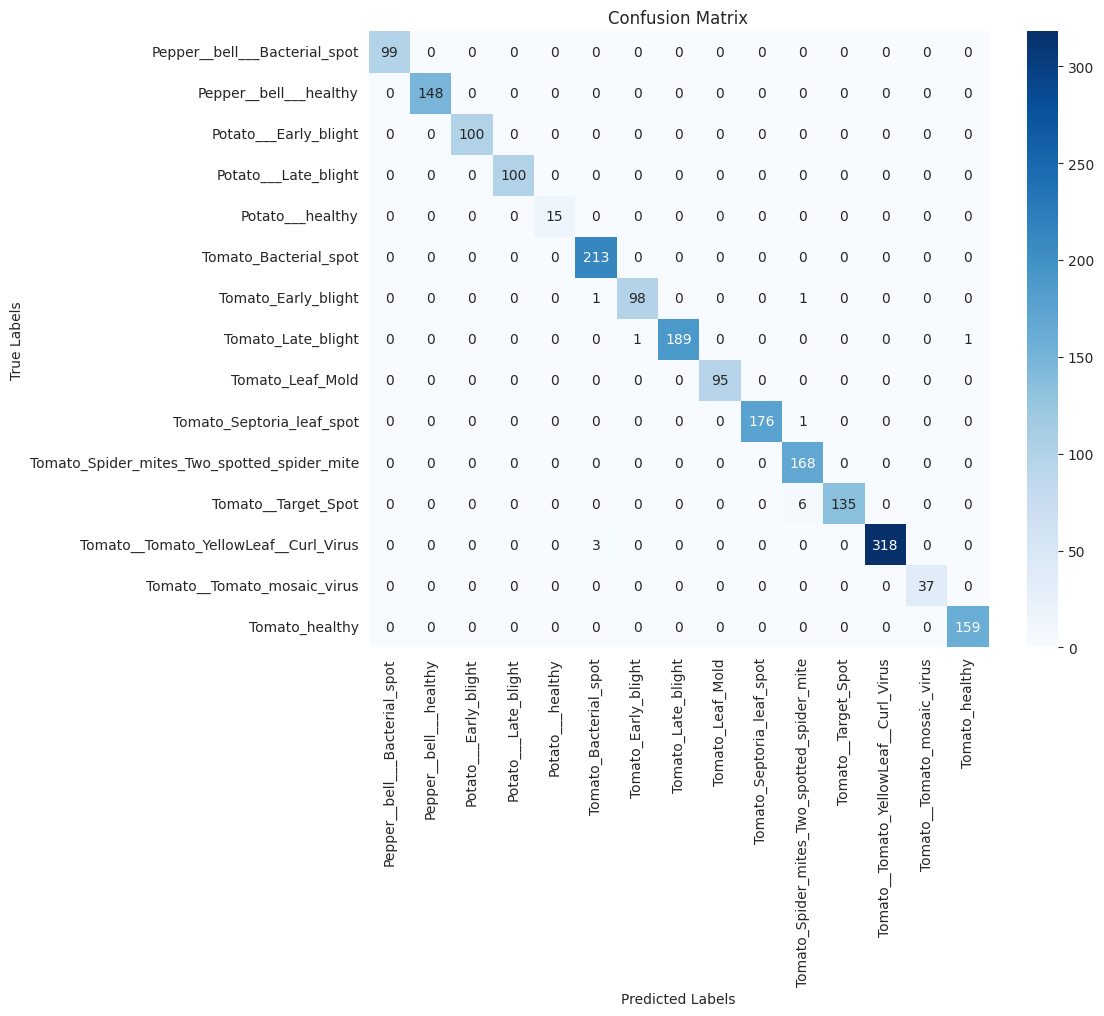

NameError: name 'base_model_v2' is not defined

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming you have train_gen, valid_gen, and test_gen defined

# Input shape
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes

# Define MobileNet base model with pretrained ImageNet weights
base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model = Model(inputs=base_model.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Training parameters
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True)
# ]
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute metrics function
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

# Usage example for MobileNet with ImageNet weights
compute_metrics(model, test_gen)


In [15]:
import time
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np

# Function to compute various metrics for a given model
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params:,}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
        )
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

    # Calculate total activations, ignoring None shapes
    total_activations = sum(np.prod(shape) for shape in activation_counts.values() if None not in shape)
    print(f"Total number of activations: {total_activations:,}")

# Example usage
model = MobileNet()
# Assuming test_gen is defined elsewhere
# compute_metrics(model, test_gen)


# Usage example for MobileNet with ImageNet weights
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
model_v1 = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))


compute_metrics(model_v1, test_gen)

Total number of parameters: 3,228,864
Estimated memory usage: 12.32 MB
1/1 [==============================] - 1s 620ms/step
Inference time for a single input: 0.690362 seconds
Total FLOPs: 0
Activation counts by layer:
input_6: (None, 224, 224, 3)
conv1: (None, 112, 112, 32)
conv1_bn: (None, 112, 112, 32)
conv1_relu: (None, 112, 112, 32)
conv_dw_1: (None, 112, 112, 32)
conv_dw_1_bn: (None, 112, 112, 32)
conv_dw_1_relu: (None, 112, 112, 32)
conv_pw_1: (None, 112, 112, 64)
conv_pw_1_bn: (None, 112, 112, 64)
conv_pw_1_relu: (None, 112, 112, 64)
conv_pad_2: (None, 113, 113, 64)
conv_dw_2: (None, 56, 56, 64)
conv_dw_2_bn: (None, 56, 56, 64)
conv_dw_2_relu: (None, 56, 56, 64)
conv_pw_2: (None, 56, 56, 128)
conv_pw_2_bn: (None, 56, 56, 128)
conv_pw_2_relu: (None, 56, 56, 128)
conv_dw_3: (None, 56, 56, 128)
conv_dw_3_bn: (None, 56, 56, 128)
conv_dw_3_relu: (None, 56, 56, 128)
conv_pw_3: (None, 56, 56, 128)
conv_pw_3_bn: (None, 56, 56, 128)
conv_pw_3_relu: (None, 56, 56, 128)
conv_pad_4: (None,

Try this for version 1. tomorrow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming you have train_gen, valid_gen, and test_gen defined

# Input shape
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes

# Define MobileNet base model with pretrained ImageNet weights
base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model = Model(inputs=base_model.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

# Training parameters
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=stop_patience, restore_best_weights=True)
# ]
callbacks = [MyCallback(model=model, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score = model.evaluate(train_gen)
valid_score = model.evaluate(valid_gen)
test_score = model.evaluate(test_gen)

print("Train Loss:", train_score[0], "Train Accuracy:", train_score[1])
print("Validation Loss:", valid_score[0], "Validation Accuracy:", valid_score[1])
print("Test Loss:", test_score[0], "Test Accuracy:", test_score[1])

# Generate predictions on test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute metrics function
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

# Usage example for MobileNet with ImageNet weights
compute_metrics(model, test_gen)


# ***Implementing MobileNet Version_2***

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

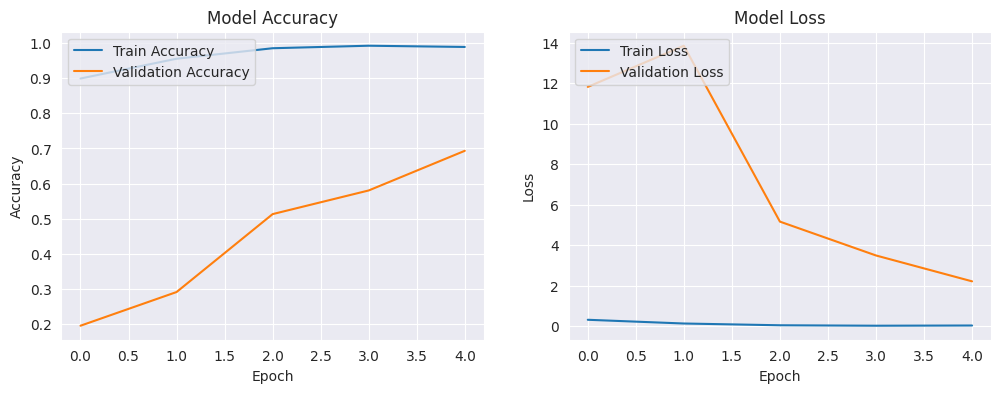

43/43 [==============================] - 4s 88ms/step - loss: 2.2668 - accuracy: 0.6778
Train Loss: 2.1752052307128906 Train Accuracy: 0.6935796737670898
Validation Loss: 2.216297149658203 Validation Accuracy: 0.6933139562606812
Test Loss: 2.266831398010254 Test Accuracy: 0.6778100728988647
43/43 [==============================] - 5s 91ms/step
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.41      1.00      0.58        99
                     Pepper__bell___healthy       1.00      0.97      0.99       148
                      Potato___Early_blight       0.98      0.99      0.99       100
                       Potato___Late_blight       1.00      0.53      0.69       100
                           Potato___healthy       1.00      0.93      0.97        15
                      Tomato_Bacterial_spot       1.00      0.09      0.16       213
                        Tomato_Earl

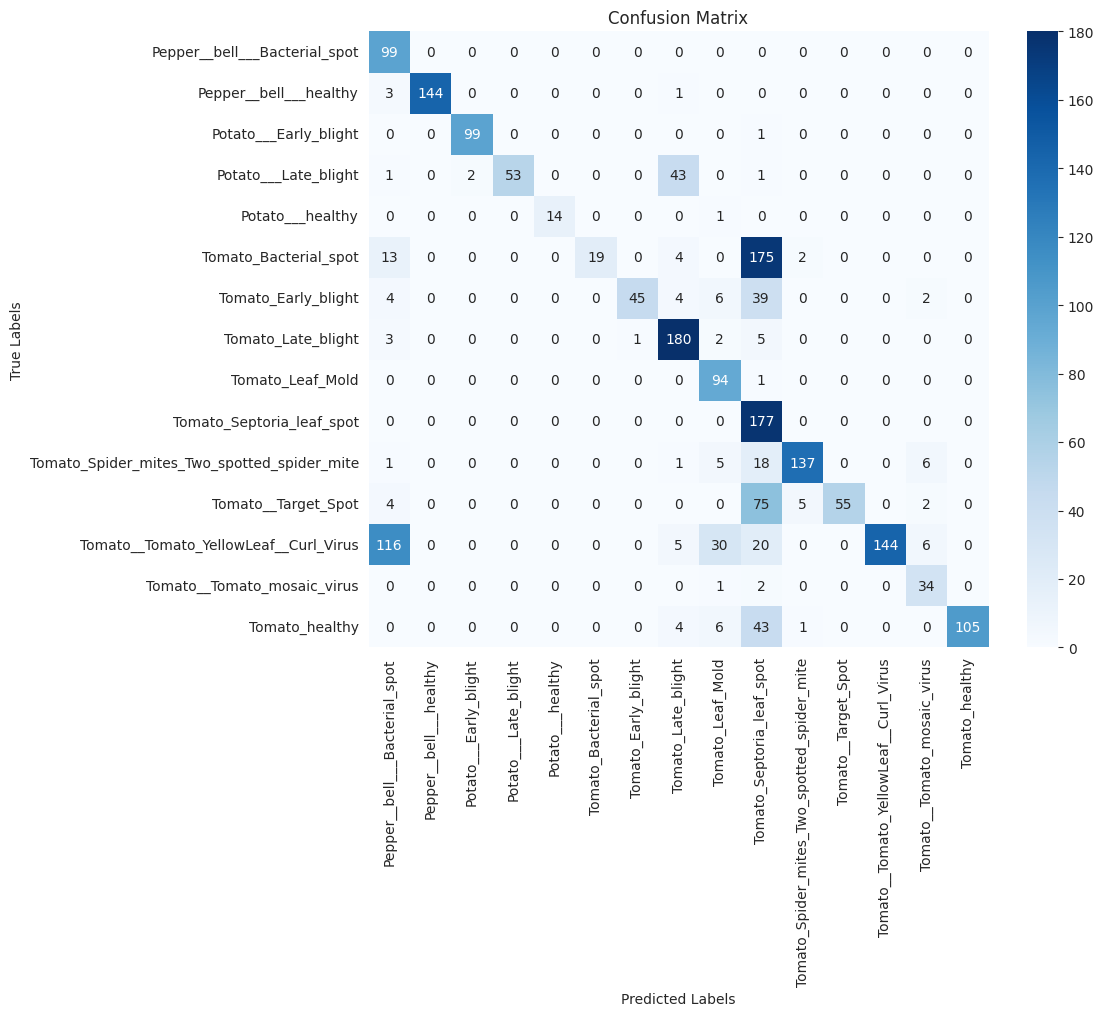

Total number of parameters: 2,277,199
Estimated memory usage: 8.69 MB
1/1 [==============================] - 1s 1s/step
Inference time for a single input: 1.329809 seconds
Total FLOPs: 0
Activation counts by layer:
input_7: (None, 224, 224, 3)
Conv1: (None, 112, 112, 32)
bn_Conv1: (None, 112, 112, 32)
Conv1_relu: (None, 112, 112, 32)
expanded_conv_depthwise: (None, 112, 112, 32)
expanded_conv_depthwise_BN: (None, 112, 112, 32)
expanded_conv_depthwise_relu: (None, 112, 112, 32)
expanded_conv_project: (None, 112, 112, 16)
expanded_conv_project_BN: (None, 112, 112, 16)
block_1_expand: (None, 112, 112, 96)
block_1_expand_BN: (None, 112, 112, 96)
block_1_expand_relu: (None, 112, 112, 96)
block_1_pad: (None, 113, 113, 96)
block_1_depthwise: (None, 56, 56, 96)
block_1_depthwise_BN: (None, 56, 56, 96)
block_1_depthwise_relu: (None, 56, 56, 96)
block_1_project: (None, 56, 56, 24)
block_1_project_BN: (None, 56, 56, 24)
block_2_expand: (None, 56, 56, 144)
block_2_expand_BN: (None, 56, 56, 144)
bl

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming train_gen, valid_gen, and test_gen are defined

# Configuration
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Define MobileNetV2 base model with pretrained ImageNet weights
base_model_v2 = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model_v2.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model_v2 = Model(inputs=base_model_v2.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_v2.summary()

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
callbacks = [MyCallback(model=model_v2, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history_v2 = model_v2.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score_v2 = model_v2.evaluate(train_gen)
valid_score_v2 = model_v2.evaluate(valid_gen)
test_score_v2 = model_v2.evaluate(test_gen)

print("Train Loss:", train_score_v2[0], "Train Accuracy:", train_score_v2[1])
print("Validation Loss:", valid_score_v2[0], "Validation Accuracy:", valid_score_v2[1])
print("Test Loss:", test_score_v2[0], "Test Accuracy:", test_score_v2[1])

# Generate predictions on test set
preds_v2 = model_v2.predict(test_gen)
y_pred_v2 = np.argmax(preds_v2, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred_v2, target_names=class_labels))

conf_matrix_v2 = confusion_matrix(y_true, y_pred_v2)
print("Confusion Matrix:")
print(conf_matrix_v2)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_v2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Function to compute various metrics for a given model
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params:,}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
        )
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

    # Calculate total activations, ignoring None shapes
    total_activations = sum(np.prod(shape) for shape in activation_counts.values() if None not in shape)
    print(f"Total number of activations: {total_activations:,}")

# Usage example for MobileNetV2
compute_metrics(model_v2, test_gen)


# ***Implementing mobileNet version_3***

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Assuming train_gen, valid_gen, and test_gen are defined

# Configuration
input_shape = (224, 224, 3)  # Define your input shape based on your images
class_count = len(train_gen.class_indices)  # Number of classes
batch_size = 40  # Set batch size for training
epochs = 40  # Number of epochs in training
patience = 1  # Number of epochs to wait to adjust learning rate if monitored value does not improve
stop_patience = 3  # Number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9  # If train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5  # Factor to reduce learning rate by
ask_epoch = 5  # Number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))  # Number of training batches to run per epoch

# Define MobileNetV3 base model with pretrained ImageNet weights
base_model_v3 = MobileNetV3Large(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers for your specific task
x = GlobalAveragePooling2D()(base_model_v3.output)
output_tensor = Dense(class_count, activation='softmax')(x)  # Adjust 'class_count' as per your needs

# Create your model
model_v3 = Model(inputs=base_model_v3.input, outputs=output_tensor)

# Compile the model (adjust optimizer and loss as per your task)
model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_v3.summary()

# Callbacks (optional, can include learning rate adjustment, early stopping, etc.)
callbacks = [MyCallback(model=model_v3, patience=patience, stop_patience=stop_patience, threshold=threshold,
                        factor=factor, batches=batches, epochs=epochs, ask_epoch=ask_epoch)]

# Train the model
history_v3 = model_v3.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=valid_gen)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(history_v3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_v3.history['loss'], label='Train Loss')
plt.plot(history_v3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate on train, validation, and test sets
train_score_v3 = model_v3.evaluate(train_gen)
valid_score_v3 = model_v3.evaluate(valid_gen)
test_score_v3 = model_v3.evaluate(test_gen)

print("Train Loss:", train_score_v3[0], "Train Accuracy:", train_score_v3[1])
print("Validation Loss:", valid_score_v3[0], "Validation Accuracy:", valid_score_v3[1])
print("Test Loss:", test_score_v3[0], "Test Accuracy:", test_score_v3[1])

# Generate predictions on test set
preds_v3 = model_v3.predict(test_gen)
y_pred_v3 = np.argmax(preds_v3, axis=1)  # Get predicted labels

# Print classification report and confusion matrix
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred_v3, target_names=class_labels))

conf_matrix_v3 = confusion_matrix(y_true, y_pred_v3)
print("Confusion Matrix:")
print(conf_matrix_v3)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_v3, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Function to compute various metrics for a given model
def compute_metrics(model, test_gen):
    # Parameter Count
    total_params = model.count_params()
    print(f"Total number of parameters: {total_params:,}")

    # Memory Usage
    memory_usage = total_params * 4 / (1024 ** 2)  # Assuming 32-bit precision
    print(f"Estimated memory usage: {memory_usage:.2f} MB")

    # Inference Time
    input_data = tf.random.normal([1] + list(model.input_shape[1:]))  # Example input tensor
    start_time = time.time()
    model.predict(input_data)
    end_time = time.time()
    inference_time = end_time - start_time
    print(f"Inference time for a single input: {inference_time:.6f} seconds")

    # FLOPs Calculation
    def get_flops(model):
        concrete_func = tf.function(lambda x: model(x))
        concrete_func = concrete_func.get_concrete_function(
            tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
        )
        frozen_func = convert_variables_to_constants_v2(concrete_func)
        graph = frozen_func.graph
        with tf.Graph().as_default() as g:
            tf.import_graph_def(graph.as_graph_def(), name='')
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            flops = tf.compat.v1.profiler.profile(g, run_meta=run_meta, cmd='op', options=opts)
            return flops.total_float_ops

    flops = get_flops(model)
    print(f"Total FLOPs: {flops:,}")

    # Activation Count
    def get_activation_count(model):
        activations = {}
        for layer in model.layers:
            if hasattr(layer, 'output'):
                activations[layer.name] = layer.output.shape
        return activations

    activation_counts = get_activation_count(model)
    print("Activation counts by layer:")
    for layer_name, shape in activation_counts.items():
        print(f"{layer_name}: {shape}")

    # Calculate total activations, ignoring None shapes
    total_activations = sum(np.prod(shape) for shape in activation_counts.values() if None not in shape)
    print(f"Total number of activations: {total_activations:,}")

# Usage example for MobileNetV3
compute_metrics(model_v3, test_gen)


12683000/12683000 [==============================] - 2s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_8[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                 